## **Step-1:Importing the necessary Libraries**

In [3]:
!pip install gtts
# This is google text to speech library which I will be using ahead to convert the text into
# speech

In [46]:
#These are all the important libraries that I will need along the way to make my project
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
from tensorflow.keras import layers, models
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import io
from gtts import gTTS
import IPython.display as ipd
from keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix

## **Step-2: Loading the data and reading it as an array**

I have a drive folder named reduced_size_train which further has 27 folders named **A through Z** including one folder for **space**.
Each of these folders has about 100 files each. Originally the data I downloaded from kaggle had 1000 files in each folder but because of the limited space availaible on google drive, I reduced the size to **100 images per folder.**

In [33]:
#This is the folder containing other folders which further has images
data_root = '/content/drive/MyDrive/reduced_size_train'
#subfolders are the folders containg images of each alphabat and space.
subfolders = sorted([f.path for f in os.scandir(data_root) if f.is_dir()])

images =[]
labels = []
counter =0  # This is the variable to keep track of the label of alphabat
            # and append the label accordingly into the labels array
#Reading the images of each folder into an array called images
for folder_path in subfolders:
    folder_name = os.path.basename(folder_path)
    file_list = sorted([f.path for f in os.scandir(folder_path) if f.is_file()])
    print(f"Folder: {folder_name}, Number of files: {len(file_list)}")
    for file_path in file_list:
        image = cv2.imread(file_path)                   #Reading the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  #Converting the images to RGB format
        images.append(image)
        labels.append(counter)
    counter+=1

Folder: A, Number of files: 100
Folder: B, Number of files: 100
Folder: C, Number of files: 100
Folder: D, Number of files: 100
Folder: E, Number of files: 100
Folder: F, Number of files: 100
Folder: G, Number of files: 100
Folder: H, Number of files: 100
Folder: I, Number of files: 100
Folder: J, Number of files: 100
Folder: K, Number of files: 100
Folder: L, Number of files: 100
Folder: M, Number of files: 100
Folder: N, Number of files: 100
Folder: O, Number of files: 100
Folder: P, Number of files: 100
Folder: Q, Number of files: 100
Folder: R, Number of files: 100
Folder: S, Number of files: 110
Folder: T, Number of files: 110
Folder: U, Number of files: 100
Folder: V, Number of files: 100
Folder: W, Number of files: 110
Folder: X, Number of files: 100
Folder: Y, Number of files: 100
Folder: Z, Number of files: 100
Folder: space, Number of files: 100


In [34]:

#This is the dataframe I have made which maps the image to its corrosponding label
df = pd.DataFrame({'Images': images, 'Labels': labels})

#Let's also shuffle it so later on we can split it into training and test data with all letters
# randomly distributed between training and test data
shuffled_df = df.sample(frac=1).reset_index(drop=True)
shuffled_df

,Images,Labels
0,"[[[0, 2, 254], [1, 2, 253], [6, 0, 247], [9, 0...",2
1,"[[[0, 4, 253], [0, 6, 252], [0, 2, 241], [3, 4...",19
2,"[[[0, 3, 252], [0, 2, 251], [4, 3, 247], [5, 0...",14
3,"[[[0, 3, 252], [0, 9, 255], [0, 0, 239], [3, 2...",7
4,"[[[0, 2, 252], [0, 6, 254], [0, 0, 239], [6, 3...",20
...,...,...
2725,"[[[0, 5, 255], [0, 1, 250], [4, 0, 247], [3, 0...",2
2726,"[[[0, 6, 255], [0, 3, 250], [1, 3, 248], [2, 1...",11
2727,"[[[0, 3, 252], [0, 9, 255], [0, 0, 243], [1, 0...",8
2728,"[[[0, 5, 250], [0, 4, 248], [3, 0, 243], [5, 0...",5


Length of images array: 2730
Length of labels array: 2730


array([[[  0,   1, 251],
        [  0,   6, 254],
        [  1,   0, 242],
        ...,
        [  7,   1, 249],
        [  0,   0, 249],
        [  0,   3, 252]],

       [[  0,   5, 255],
        [  0,   0, 233],
        [ 10,   9, 209],
        ...,
        [ 10,   1, 192],
        [  8,   8, 218],
        [  2,   6, 225]],

       [[  4,   0, 251],
        [ 12,   8, 217],
        [ 76,  77, 193],
        ...,
        [ 72,  60, 136],
        [ 60,  53, 185],
        [ 13,   9, 168]],

       ...,

       [[  3,   3, 247],
        [  8,   9, 198],
        [ 21,  22, 104],
        ...,
        [116, 111, 117],
        [111, 109, 192],
        [ 12,  14, 133]],

       [[  0,   1, 246],
        [  3,   5, 214],
        [  9,   8, 146],
        ...,
        [110, 108, 191],
        [ 96, 100, 226],
        [  7,  14, 164]],

       [[  0,   1, 248],
        [  4,   7, 226],
        [ 10,   8, 177],
        ...,
        [ 13,  15, 134],
        [  7,  13, 163],
        [  6,  15, 180]]], dtype=uint8)
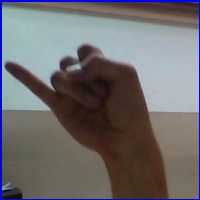

In [35]:
#Visualising the data
print("Length of images array:", len(images))
print("Length of labels array:", len(labels))
images[990]


## **Step-3: Defining the model**

In [36]:
images[0].shape

(200, 200, 3)

In [37]:

input_shape = (200,200, 3) #This is based on the size of images downloaded from data itself

# Define the number of classes which the model will use for multi-class classification
num_classes = 27

# Model architecture- Almost similar to what i used for my face recognition project
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compiling the model with adam optimizer and sparse categorical crossentropy (pretty standard)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Printing the model summary helps to understand the architecture of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 147456)            0         
                                                                 
 dense (Dense)               (None, 128)               1

## **Step-4: Dividing the data into training and test data**

In [38]:
# First of all the image file is being read as a numpy array and then it is converted to tensor
# because the model architecture has a tensor input

# Same process is repeated for training as well as test data

X_train = np.array([np.array(image) for image in shuffled_df['Images'][:2000]])
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)

X_val = np.array([np.array(image) for image in shuffled_df['Images'][2000:]])
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)

y_train = np.array(shuffled_df['Labels'][:2000])
y_train = tf.convert_to_tensor(y_train, dtype=tf.int64)

y_val = np.array(shuffled_df['Labels'][2000:])
y_val = tf.convert_to_tensor(y_val, dtype=tf.int64)




## **Step-5: Fitting the model and tracking the accuracy of the model**

In [39]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
63/63 [==============================] - 182s 3s/step - loss: 205.8720 - accuracy: 0.5775 - val_loss: 0.1537 - val_accuracy: 0.9630
Epoch 2/5
63/63 [==============================] - 162s 3s/step - loss: 0.0362 - accuracy: 0.9910 - val_loss: 0.0247 - val_accuracy: 0.9932
Epoch 3/5
63/63 [==============================] - 178s 3s/step - loss: 0.0361 - accuracy: 0.9905 - val_loss: 0.0989 - val_accuracy: 0.9753
Epoch 4/5
63/63 [==============================] - 217s 3s/step - loss: 0.0326 - accuracy: 0.9940 - val_loss: 0.0995 - val_accuracy: 0.9767
Epoch 5/5
63/63 [==============================] - 175s 3s/step - loss: 0.0155 - accuracy: 0.9955 - val_loss: 0.0906 - val_accuracy: 0.9726


Validation accuracy of about 97% in last epoch was achieved

## **Step-6: Checking the accuracy of the fitted model on test data**

In [41]:
# Test images that were defined above
test_images = X_val

#Converting the images into tensors because that is how the model input was defined
X_test = np.array([np.array(image) for image in test_images])
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

#Using the model to predict the probability of each label
predictions = model.predict(X_test, batch_size=len(test_images), steps=1)

#Calculating the most probable label for each of the image
predicted_labels = np.argmax(predictions, axis=1)


1/1 [==============================] - 18s 18s/step


In [44]:
#Calculating the accuracy of model by comparing the predicted outputs with actual output
accuracy = accuracy_score(y_val, predicted_labels)

#Printing the final accuracy of model on test data
print("Accuracy of model on test data is :   " , accuracy*100, "%")

Accuracy of model on test data is :    97.26027397260275 %


## **Step-7: Saving the model**

In [49]:
model.save('/content/drive/MyDrive/EE_769_project/Sign_2_Speech_model')

## **Step-8: Loading the model and performing the final performance by converting a set of images to speech**

In [50]:
model = load_model('/content/drive/MyDrive/EE_769_project/Sign_2_Speech_model')

For this I will be using a bunch of images I have uploaded in a folder with images in sign language. The aim is to convert the images into speech.

In [52]:
# Function to read the files
def read_image_files(folder_path):
    image_files = []
    filenames = sorted(os.listdir(folder_path), key=lambda x: int(os.path.splitext(x)[0]))
    for filename in filenames:
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png') or filename.endswith('.gif'):
            image_files.append(cv2.imread(os.path.join(folder_path, filename)))
    return image_files

#Reading the imafe files
folder_path = '/content/drive/MyDrive/EE_769_project/Final_test'
image_files = read_image_files(folder_path)

In [53]:
# Just like before, converting the image files into tensors
X_test = np.array([np.array(image) for image in image_files])
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

#Making the predictions using the loaded model
predictions = model.predict(X_test, batch_size=len(X_test), steps=1)
predicted_labels = np.argmax(predictions, axis=1)

1/1 [==============================] - 1s 785ms/step


In [54]:
# Mapping each label to their respective labels
label_to_alphabet = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J',
                     10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S',
                     19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: ' '}

#Generating alphabats from their labels
alphabet_labels = [label_to_alphabet[label] for label in predicted_labels]

#A string is generated from these alphabats which then needs to be converted to speech
text_string = ''.join(alphabet_labels)

#Using Google TTS to generate speech
tts = gTTS(text=text_string, lang='en')

# Save speech to an in-memory file-like object
mp3_fp = io.BytesIO()
tts.write_to_fp(mp3_fp)

In [55]:
# Playing the Audio
ipd.display(ipd.Audio(mp3_fp.getvalue(), autoplay=True))